### This Notebook uses given pre-trained model and fine tune it on the available data

In [1]:
import torch
import pickle
import pandas as pd
import numpy as np
import torch.optim as optim
import matplotlib.pyplot as plt
from fastai import data_block, basic_train, basic_data
from fastai.callbacks import ActivationStats
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
import fastai
from network import Network, get_data, AE_3D_200
import torch.nn as nn
import my_matplotlib_style as ms
import matplotlib.gridspec as gridspec
from sklearn.model_selection import train_test_split
from fastai import train as tr

In [2]:
# load the data
train = pd.read_pickle('data/all_jets_train_4D_100_percent.pkl')
test = pd.read_pickle('data/all_jets_test_4D_100_percent.pkl')

In [3]:
train = train.astype(np.float32)
test = test.astype(np.float32)

In [4]:
train.head()

,m,pt,phi,eta
132784,3831.839355,22000.609375,1.567018,1.142924
99666,4582.417480,21648.210938,-2.680558,0.213654
26629,16747.765625,169514.281250,-1.948239,1.163296
80473,14789.586914,183085.609375,-1.641102,2.670927
48229,4646.724121,20527.130859,2.922270,-1.158871


### Plots for training data before normalising

Box plots allows us to check the data distribution through many statistics like interquartile range, median of the distribution.<br>  
As it could be seen from the box plots that two variables 'm' and 'pt' are right skewed but 'pt' is more skewed than former. Therefore, they have long more dispersion in upper quartile. Interesting thing here is that box plot is interpreting lots of the values as outliers. The black rings after the right whisker are considered outliers. 

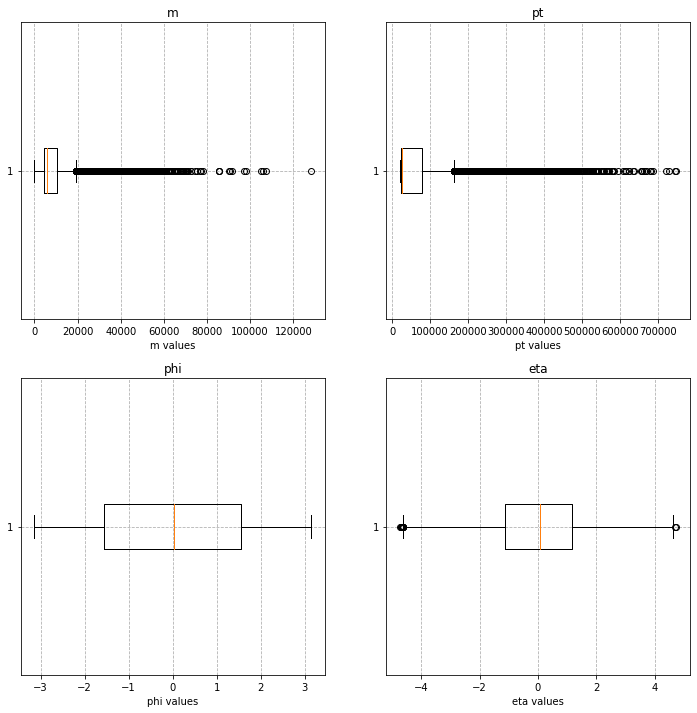

In [6]:
# box plots for training data

fig3 = plt.figure(figsize=(12, 12))
gs = fig3.add_gridspec(2, 2)

last = 0
for value in range(4):
    f3_ax1 = fig3.add_subplot(gs[last, value%2])
    f3_ax1.boxplot(train.iloc[:, value], vert = False)
    f3_ax1.set_title(train.columns[value])
    plt.xlabel(train.columns[value] + ' values')
    plt.grid(linestyle = '--')
    last = value %2
    if value == 2:
        last = 1


__Plot histogram__: Histogram let's us see the data distribution, they are the frequency plots. On y-axis it shows the 'number of events' for a value in the experiment meaning during experiment how many times it got that particular value. As it can be seen from the plots that data is very skewed with long right tail. 

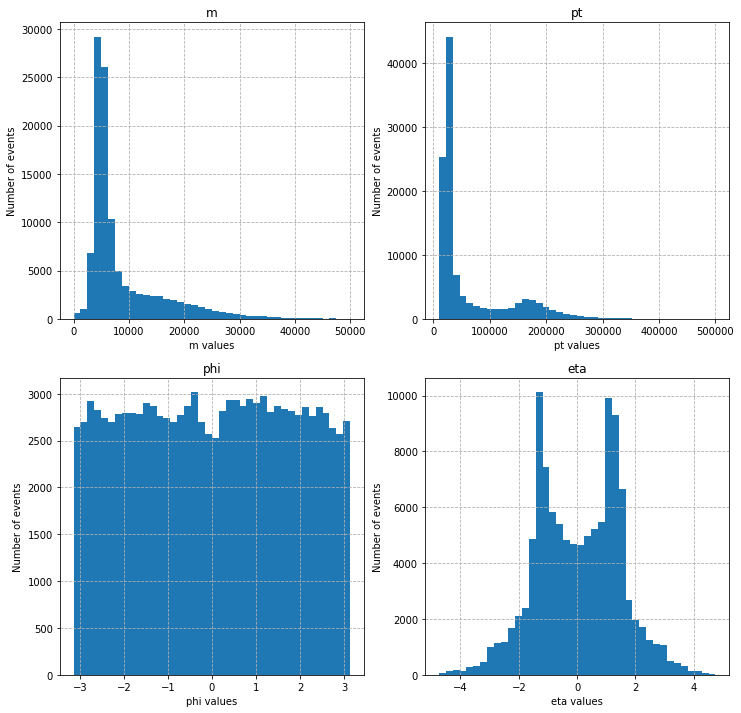

In [8]:
# plot histograms for train data

ranges = [(0, 50000), (10000, 500000), None, None]

fig3 = plt.figure(figsize=(12, 12))
gs = fig3.add_gridspec(2, 2)

last = 0
for value in range(4):
    f3_ax1 = fig3.add_subplot(gs[last, value%2])
    f3_ax1.hist(train.iloc[:, value], bins = 40, range = ranges[value])
    f3_ax1.set_title(train.columns[value])
    plt.xlabel(train.columns[value] + ' values')
    plt.ylabel('Number of events')
    plt.grid(linestyle = '--')
    last = value %2
    if value == 2:
        last = 1

#### Create validation set from train data as this will be used by the network to check the reconstruction error at each epoch
__Please Note:__  In Skelpdar's notebooks directly test data has been used as validation set which is not the good approach as we would not like our network to see the test data till very end.<br>

I have also normalized the data here using train data mean and standard deviation. This is important step in pre processing as it helps the machine learning models converge faster. 

In [5]:
# Normalize using train data mean and std
train_mean = train.mean()
train_std = train.std()

train = (train - train_mean) / train_std
test = (test - train_mean) / train_std

# create validation set from train data
train_x, valid_x, train_y, valid_y = train_test_split(train, train, test_size=0.20, random_state=42)

train_ds = TensorDataset(torch.tensor(train_x.values), torch.tensor(train_y.values))
valid_ds = TensorDataset(torch.tensor(valid_x.values), torch.tensor(valid_y.values))
test_ds = TensorDataset(torch.tensor(test.values), torch.tensor(test.values))

In [6]:
print('Train data shape {}, validation data shape {} and Test data shape {}'.format(train_x.shape, valid_x.shape, test.shape))

Train data shape (89422, 4), validation data shape (22356, 4) and Test data shape (27945, 4)


#### Train the network 

In [12]:
# create data loaders for validation and 
train_dl, valid_dl, test_dl = get_data(train_ds, valid_ds, bs=128, test_ds = test_ds)
# load the model
model = AE_3D_200().cuda()

db = basic_data.DataBunch(train_dl, valid_dl)

In [13]:
loss_func = nn.MSELoss()
# Don't use weight decay for batchnorm layers
bn_wd = False  
true_wd = True 
wd = 1e-4
learn = basic_train.Learner(data=db, model=model,loss_func=loss_func, wd=wd,
                            bn_wd=bn_wd, true_wd=true_wd, train_bn = True)

In [14]:

# find a learning rate
tr.lr_find(learn)

epoch,train_loss,valid_loss,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


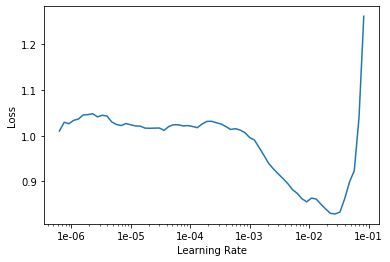

In [15]:
learn.recorder.plot()

<br>

__learning rate__: Here any value from 1e-03 to 1e-02 would be fine as learning rate <br>
__Note__: Normally, this will be big learning rate for pre-trained model as it would update the network's weights with big step which we may not want for a pre-trained model but I tried smaller learning rate first and they did not help to reduce the loss by much so I choose slightly bigger learning rate.

In [16]:
# load the pre trained model
learn.load('AE_3D_200_no1cycle_trainforever')

Learner(data=DataBunch;

Train: <torch.utils.data.dataset.TensorDataset object at 0x0000014F69ACA160>;

Valid: <torch.utils.data.dataset.TensorDataset object at 0x0000014F72AF47B8>;

Test: None, model=AE_3D_200(
  (en1): Linear(in_features=4, out_features=200, bias=True)
  (en2): Linear(in_features=200, out_features=100, bias=True)
  (en3): Linear(in_features=100, out_features=50, bias=True)
  (en4): Linear(in_features=50, out_features=3, bias=True)
  (de1): Linear(in_features=3, out_features=50, bias=True)
  (de2): Linear(in_features=50, out_features=100, bias=True)
  (de3): Linear(in_features=100, out_features=200, bias=True)
  (de4): Linear(in_features=200, out_features=4, bias=True)
  (tanh): Tanh()
), opt_func=functools.partial(<class 'torch.optim.adam.Adam'>, betas=(0.9, 0.99)), loss_func=MSELoss(), metrics=[], true_wd=True, bn_wd=False, wd=0.0001, train_bn=True, path=WindowsPath('.'), model_dir='models', callback_fns=[functools.partial(<class 'fastai.basic_train.Recorder'>, add_

<br>

Training using fit_one_cyle method from fastai library, this method is slightly different than the fit method. This method uses cyclical learning rate. A maximum value for learning rate could be passed to the function, during training first it will start from very small learning rate and goes to the maximum value gradually. Then it will start to decrease it and in last few epochs it uses cosine annealing to tune the learning rate. 

In [23]:
learn.fit_one_cycle(50, max_lr = 0.001)

epoch,train_loss,valid_loss,time
0,0.083279,0.078578,00:40
1,0.030599,0.031901,00:41
2,0.026687,0.027556,00:44
3,0.024920,0.025682,00:43
4,0.022242,0.023471,00:42
5,0.019699,0.022567,00:40
6,0.021651,0.022401,00:15
7,0.022631,0.021540,00:16
8,0.020467,0.020299,00:17
9,0.019602,0.020440,00:16


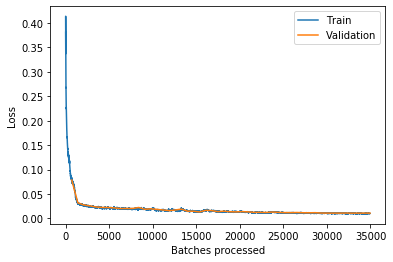

In [24]:
# plot the losses
learn.recorder.plot_losses()

<br>

I again fine tuned the network for few epochs using a smaller learning rate as we don't want to lose the information we learnt during first training. 

In [30]:
learn.fit_one_cycle(15, max_lr = 0.0003)

epoch,train_loss,valid_loss,time
0,0.010818,0.011117,00:15
1,0.010969,0.011100,00:17
2,0.010761,0.011127,00:19
3,0.011410,0.011694,00:15
4,0.010405,0.011287,00:13
5,0.011043,0.011433,00:13
6,0.010364,0.010681,00:12
7,0.009906,0.010542,00:12
8,0.010597,0.010829,00:11
9,0.009200,0.010234,00:15


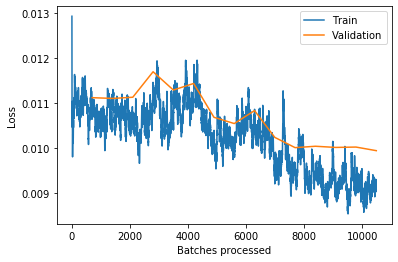

In [31]:
# plot the losses
learn.recorder.plot_losses()

### Test data compared to it's compressed representation  

These plots compare the test data and it's compressed representation

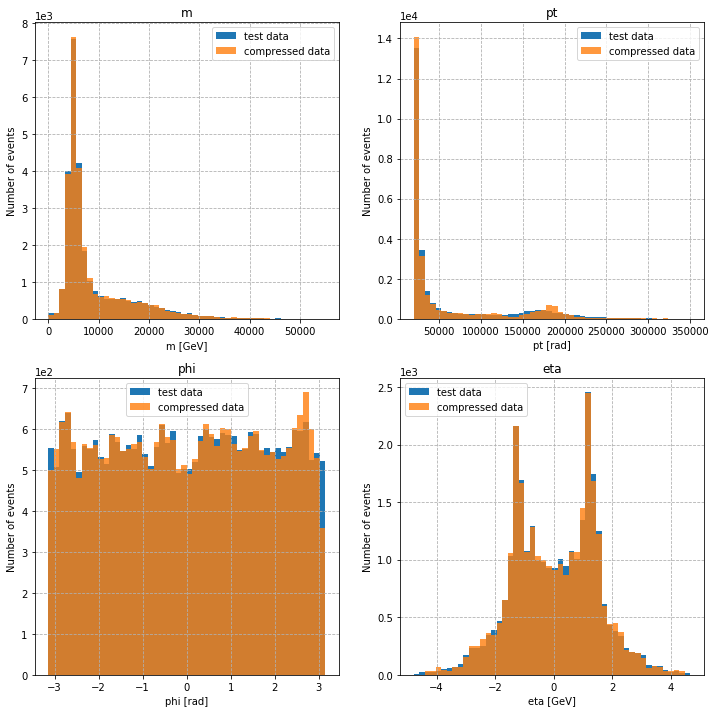

In [193]:
plt.close('all')
unit_list = ['[GeV]', '[rad]', '[rad]', '[GeV]']
line_style = ['--', '-']
ranges = [(0, 55000), (20000, 350000), None,None]

test_x, test_y = test, test

data = torch.tensor(test_x.values)
# get compressed representation of test data

pred = model(data.cuda()).detach().cpu().numpy()
# unnormalize the compressed data
pred = np.multiply(pred, train_std.values)
pred = np.add(pred, train_mean.values)
# unormalize the test data
data = data.cpu().numpy()
data = np.multiply(data, train_std.values)
data = np.add(data, train_mean.values)

fig3 = plt.figure(figsize=(12, 12))
gs = fig3.add_gridspec(2, 2)

last = 0
n_bins = 50
for value in [0,1,2,3]:
    f3_ax1 = fig3.add_subplot(gs[last, value%2])
    n_hist_data, bin_edges, _ = f3_ax1.hist(data[:, value], label='test data', alpha=1, bins=n_bins, range = ranges[value])
    n_hist_pred, _, _ = f3_ax1.hist(pred[:, value], label='compressed data', alpha=0.8, bins=bin_edges)
    f3_ax1.set_title(test_x.columns[value])
    plt.xlabel(test_x.columns[value] + ' ' + unit_list[value])
    plt.ylabel('Number of events')
    ms.sciy()
    plt.legend()
    plt.grid(linestyle = '--')
    last = value %2
    if value == 2:
        last = 1



### Visualize Residuals for each variable

Residuals interprets the difference between actual data and the predicted data. 

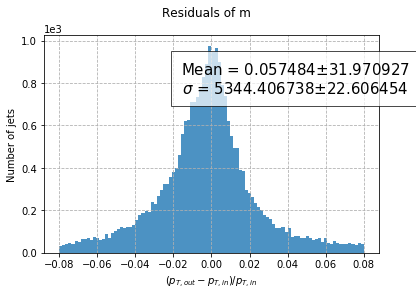

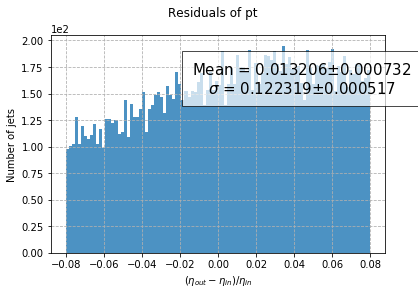

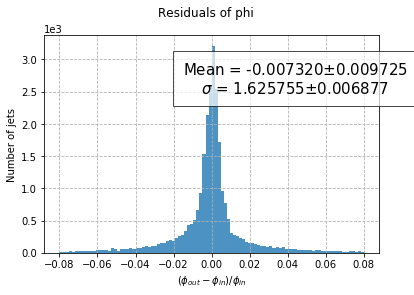

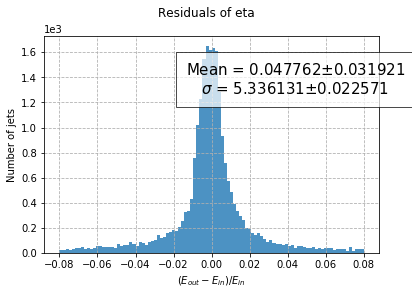

In [198]:

from network import std_error
from scipy import stats
residual_strings = [r'$(p_{T,out} - p_{T,in}) / p_{T,in}$',
                        r'$(\eta_{out} - \eta_{in}) / \eta_{in}$',
                        r'$(\phi_{out} - \phi_{in}) / \phi_{in}$',
                        r'$(E_{out} - E_{in}) / E_{in}$']

# calculate residuals between predictions and test data
data = np.where(data == 0., 1., data)
residuals = (pred - data) / data
range = (-.08, .08)

for value in np.arange(4):
    plt.figure()
    n_hist_pred, bin_edges, _ = plt.hist(
        residuals[:, value], label='Residuals', linestyle=line_style[0], alpha=0.8, bins=100, range= range)
    plt.suptitle('Residuals of %s' % train.columns[value])
    plt.xlabel(residual_strings[value])
    plt.ylabel('Number of jets')
    plt.grid(linestyle = '--')
    ms.sciy()
    
    # calculate stabdard deviation of residual
    std = np.std(residuals[:, value])
    std_err = std_error(residuals[:, value])
    # calculate mean 
    mean = np.nanmean(residuals[:, value])
    sem = stats.sem(residuals[:, value], nan_policy='omit')
    ax = plt.gca()
    plt.text(.75, .8, 'Mean = %f$\pm$%f\n$\sigma$ = %f$\pm$%f' % (mean, sem, std, std_err), bbox={'facecolor': 'white', 'alpha': 0.7, 'pad': 10},
             horizontalalignment='center', verticalalignment='center', transform=ax.transAxes, fontsize=15)

Here, residuals shows the error between output of autoencoder and the actual test data. Ideally we would like to have smaller mean and standard deviation for residuals, this means that on average there is small error between predicted value and actual value. As it could be seen from the graphs, variables 'm' has large standard deviation, meaning error is dispersed around mean.
These plots gives us the idea that network did not do a good job at compressing the data and learning good representation of same. 

__Note__: Histograms for 'm' variable don't look so bad as they almost overlap. But if you notice standard deviation for residual in 'm' variable is very high, this is due to few big values predicted by network which caused std to be high. I assume it's a noise in the model.

I noticed is that pre-trained network has helped a little compared to training a network from scratch. This may be due to small dataset available. 

<br>